In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

Problem: sklearn, mapie, skpro etc all use different ways of selecting quantiles/return_std etc. Many of these are requirements at class init/train time as they rely pinball loss. MDN has the superpower of not needing pinball loss and being able to select quantiles at predict time.
However, it would still be nice to add the option of `quantile` at class init time for easy comparison with existing sklearn models.  

Additionally, several sklearn models can use `return_std` at predict time. This can be added to MDN as well, again for nice comparisons with sklearn models.  

Finally, we can choose between returning the `median` (current functionality) or the `mean` of the gaussian mixture. This nuance is captured in skpro for distributional and sample based models. Calculating the mean is a pre-requisite for returning the std.

Sklearn also uses `quantile` at fit time. This could be confused with the `quantiles` at predict time.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from skmdn import MixtureDensityEstimator


# Generate dataset
n_samples = 10_000
X_full, _ = make_moons(n_samples=n_samples, noise=0.1)
X = X_full[:, 0].reshape(-1, 1)  # Use only the first column as input
Y = X_full[:, 1].reshape(-1, 1)  # Predict the second column

# Add some noise to Y to make the problem more suitable for MDN
Y += 0.1 * np.random.randn(n_samples, 1)

# Existing functionality

Median on predict.

In [4]:
mdn = MixtureDensityEstimator()
mdn.fit(X, Y)

MixtureDensityEstimator()

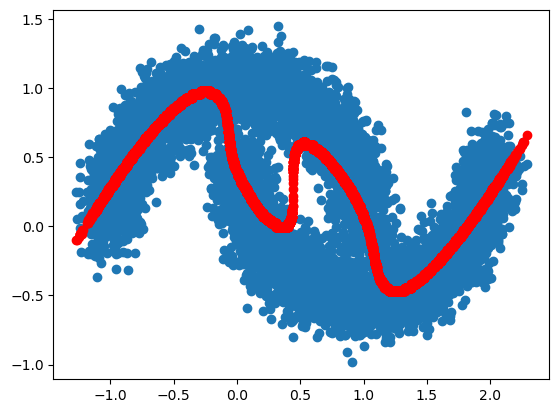

In [5]:
pred_median = mdn.predict(X)

plt.scatter(X, Y)
plt.scatter(X, pred_median, color='red')

Quantile at fit-time to compare to QuantileRegressor passing `quantile=0.1`. This makes it super easy for users to compare the two models without worrying about passing kwargs to the predict method.

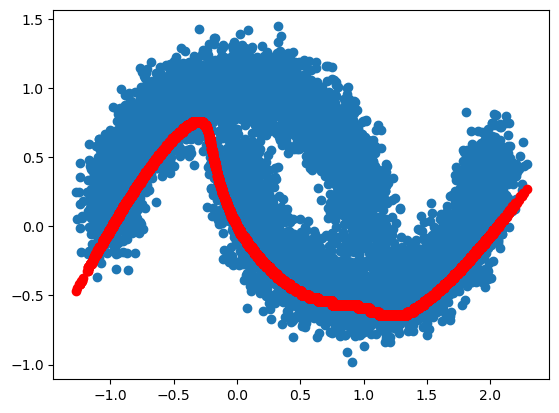

/Users/josh/mambaforge/envs/scikit-mdn/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


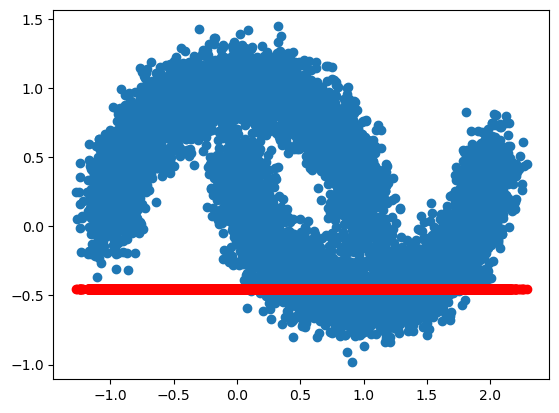

(10000, 3)

In [6]:
from sklearn.linear_model import QuantileRegressor

kwargs = {'quantile': 0.1}
q1_ests = [MixtureDensityEstimator(**kwargs), QuantileRegressor(**kwargs)]

for q1_est in q1_ests:
    q1_est.fit(X, Y)
    q1 = q1_est.predict(X)
    plt.scatter(X, Y)
    plt.scatter(X, q1, color='red')
    plt.show()

# you can still pass `quantiles`=[0.1, 0.5, 0.9] to the `predict` method
multi_q_pred = mdn.predict(X, quantiles=[0.1, 0.5, 0.9])
multi_q_pred.shape

You can still pass `quantiles`=[0.1, 0.5, 0.9] to the `predict` method. This overrides the `quantile` at fit-time.

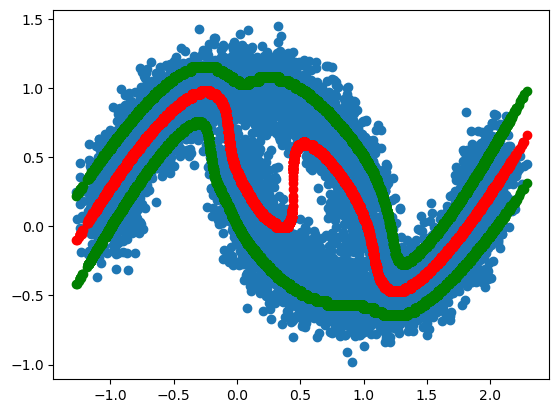

In [7]:
multi_q_pred = mdn.predict(X, quantiles=[0.1, 0.5, 0.9])

plt.scatter(X, Y)
plt.scatter(X, multi_q_pred[:, 0], color='green')
plt.scatter(X, multi_q_pred[:, 1], color='red')
plt.scatter(X, multi_q_pred[:, 2], color='green')

# New Feature

Mean prediction Eqn 45 in MDN - C. Bishop.  

This can be passed as an override to the `predict` method. Here we are using the original `mdn` estimator.

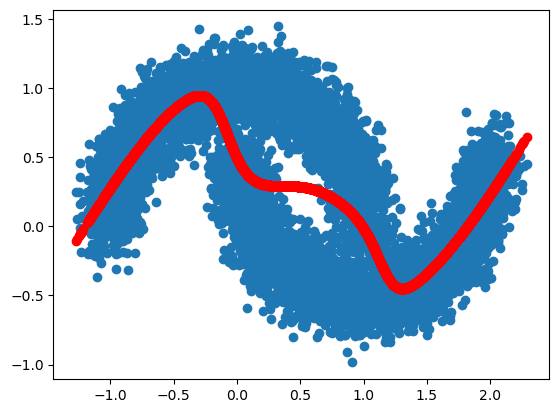

In [8]:
mean = mdn.predict(X, return_mean=True)

plt.scatter(X, Y)
plt.scatter(X, mean, color='red')

Mean and std at predict time. std calculated as the square root of the variance Eqn 47 in MDN - C. Bishop

Conforms with sklearn `return_std`.

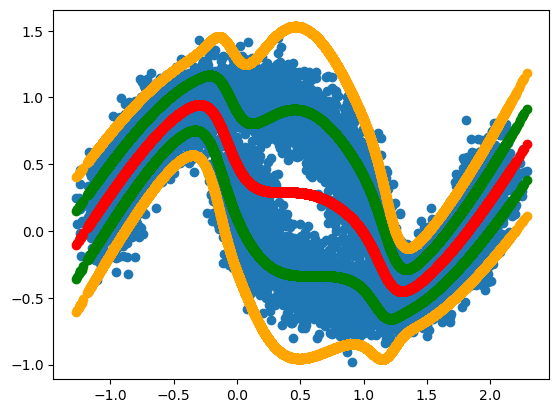

In [9]:
mean, std = mdn.predict(X, return_mean=True, return_std=True)

plt.scatter(X, Y)
plt.scatter(X, mean + std, color='green')
plt.scatter(X, mean - std, color='green')
plt.scatter(X, mean + std * 2, color='orange')
plt.scatter(X, mean - std * 2, color='orange')
plt.scatter(X, mean, color='red')

We can also train a new model with `return_mean` as the target. This means we can fit and predict an estimator and not pass non-sklearn typical parameters at predict time.  

The bonus here is that we can still override this at predict time by passing `return_mean=False` to the `predict` method.

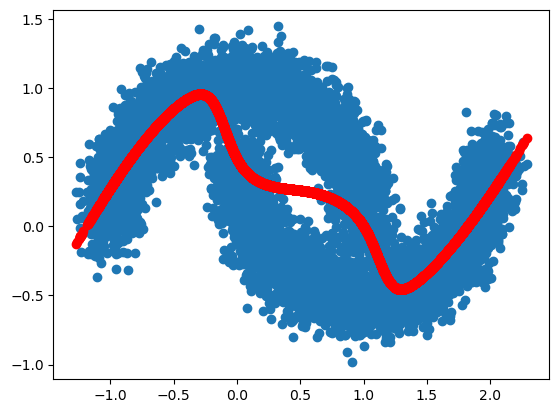

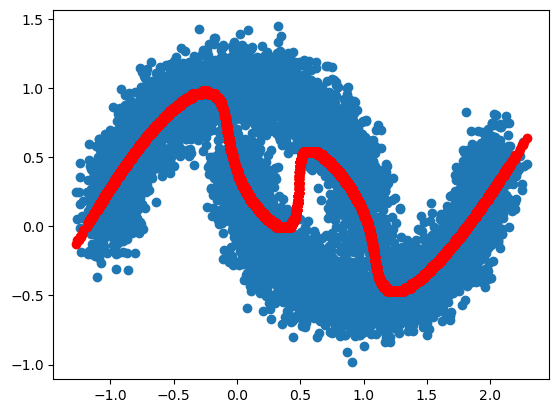

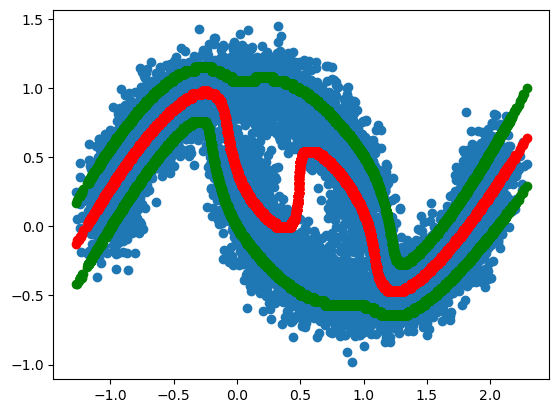

In [10]:
mdn_mean = MixtureDensityEstimator(return_mean=True)
mdn_mean.fit(X, Y)
mean = mdn_mean.predict(X)

plt.scatter(X, Y)
plt.scatter(X, mean, color='red')
plt.show()

# turn off return_mean which defaults to median/0.5 quantile
median_pred = mdn_mean.predict(X, return_mean=False)

plt.scatter(X, Y)
plt.scatter(X, median_pred, color='red')
plt.show()

# you can also pass `quantiles`=[0.1, 0.5, 0.9] to the `predict` method
multi_q_pred = mdn_mean.predict(X, return_mean=False, quantiles=[0.1, 0.5, 0.9])

plt.scatter(X, Y)
plt.scatter(X, multi_q_pred[:, 0], color='green')
plt.scatter(X, multi_q_pred[:, 1], color='red')
plt.scatter(X, multi_q_pred[:, 2], color='green')
plt.show()

Example of why having `return_mean` at init and `return_std` at predict makes life super easy for users. We can just loop over estimators and not worry about passing kwargs to the predict method.

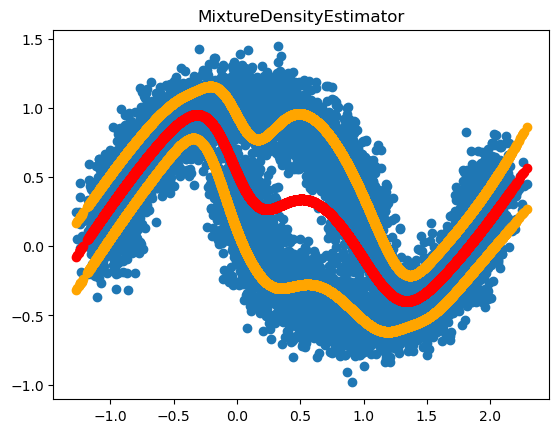

/Users/josh/mambaforge/envs/scikit-mdn/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


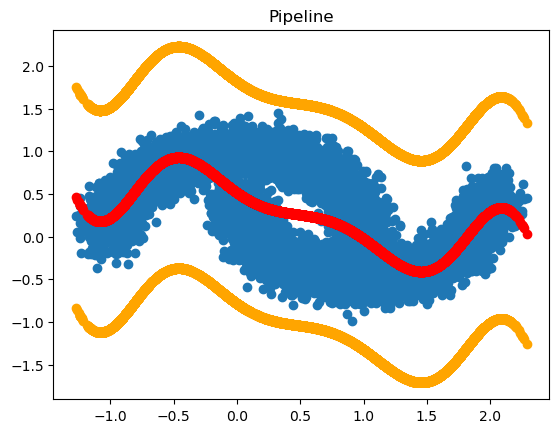

In [11]:
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import Pipeline

bayes_spline = Pipeline([
    ('spline', SplineTransformer(n_knots=7, degree=5)),
    ('bayes', BayesianRidge()),
])

ests = [MixtureDensityEstimator(return_mean=True), bayes_spline]

for est in ests:
    pred, std = est.fit(X, Y).predict(X, return_std=True)

    plt.scatter(X, Y)
    plt.scatter(X, pred, color='red')
    plt.scatter(X, pred + std, color='orange')
    plt.scatter(X, pred - std, color='orange')
    plt.title(est.__class__.__name__)
    plt.show()

You can call specfic `predict_quantile` and `predict_mean` methods.

In [12]:
mean_pred = mdn.predict_mean(X)
quantile_preds = mdn.predict_quantiles(X, quantiles=[0.1, 0.5, 0.9])

Failure messages on invalid inputs on `predict` method.

In [13]:
mdn.predict(X, return_mean=True, return_std=True, quantiles=[0.1, 0.5, 0.9])

ValueError: Cannot return both quantiles and standard deviation

In [14]:
mdn.predict(X, return_mean=True, quantiles=[0.1, 0.5, 0.9])

ValueError: Cannot return both mean and quantiles